In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np

df_train = pd.read_csv('../../../Deceptive_Opinion_Spam_Corpus_Datasets/deceptive_training_sin_proc.csv')
df_test = pd.read_csv('../../../Deceptive_Opinion_Spam_Corpus_Datasets/deceptive_testing_sin_proc.csv')

In [3]:
### Remplazar los truthful con 0 y deceptive con 1 en la columna deceptive
df_train = df_train.replace({'deceptive': {'truthful': 0, 'deceptive': 1}})
df_test = df_test.replace({'deceptive': {'truthful': 0, 'deceptive': 1}})

In [4]:
train_dec_a = df_train.iloc[:, 0]
#validation_dec_a = validation_set.iloc[:, 0]
test_dec_a = df_test.iloc[:, 0]

train_dec_a.columns = ['train_dec_a']
#validation_dec_a.columns = ['validation_dec_a']
test_dec_a.columns = ['test_dec_a']

In [5]:
print(df_train)

     deceptive                                               text
0            0  -0.19499199 -0.11689109 -1.0239629 0.589182 -0...
1            0  -0.75981146 -0.6247913 -0.5968303 0.8442113 -0...
2            0  -0.67143595 -0.34271178 -0.6285268 0.46137583 ...
3            0  -0.3716615 -0.6101102 -0.6716857 1.4250252 -0....
4            0  0.09419579 0.02537344 -0.07499692 1.4799229 -0...
..         ...                                                ...
592          0  -0.7387875 -0.31224024 -0.71631956 0.7961637 -...
593          0  -0.6691669 -0.8395288 -0.88937396 0.82928854 -...
594          0  -0.47775698 -0.21484302 -0.7292124 0.70525247 ...
595          0  -0.051372834 -0.48699462 -0.95044464 1.4210202...
596          0  -0.71351445 0.17851919 -0.258802 1.0437325 -0....

[597 rows x 2 columns]


In [6]:

x_train = ()
y_train = ()

for index, row in df_train.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_train = x_train + (res,)
    y_train = y_train + (row['deceptive'],)

x_test = ()
y_test = ()

for index, row in df_test.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_test = x_test + (res,)
    y_test = y_test + (row['deceptive'],)


In [7]:
import numpy
arrays = {}
## Train dataset
for i in range(0, len(x_train[0])):
    col_name = 'value_' + str(i)
    arrays[col_name] = numpy.array([item[i] for item in x_train])

train_ext = pd.DataFrame(y_train, columns =['deceptive'])

for x in arrays.keys(): 
    dataframe=pd.DataFrame(arrays[x], columns=[x]) 
    train_ext = train_ext.join(dataframe, how="inner")
    
train_ext = train_ext.drop(['deceptive'],axis=1)
## Test dataset

for i in range(0, len(x_test[0])):
    col_name = 'value_' + str(i)
    arrays[col_name] = numpy.array([item[i] for item in x_test])

test_ext = pd.DataFrame(y_test, columns =['deceptive'])

for x in arrays.keys(): 
    dataframe=pd.DataFrame(arrays[x], columns=[x]) 
    test_ext = test_ext.join(dataframe, how="inner")
    
test_ext = test_ext.drop(['deceptive'],axis=1)


In [8]:
import numpy as np
x_train, y_train = np.asarray(x_train), np.asarray(y_train)
#x_validation, y_validation = np.asarray(x_validation), np.asarray(y_validation)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)

x_train = x_train.astype('float32')
#x_validation = x_validation.astype('float32')
x_test = x_test.astype('float32')

In [9]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1]) # X_train 
print("Training data shape:", x_train.shape)
#x_validation = x_validation.reshape(x_validation.shape[0], 1, x_validation.shape[1]) # X_train 
#print("Validation data shape:", x_validation.shape)
X_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])     # X_test 
print("Test data shape:", x_test.shape)

Training data shape: (597, 300)
Test data shape: (198, 300)


In [10]:
print(X_train)

[[[-0.19499199 -0.11689109 -1.0239629  ... -0.3362849   0.09603526
   -0.29484585]]

 [[-0.75981146 -0.6247913  -0.5968303  ...  0.20598556 -0.4579486
    0.02073733]]

 [[-0.67143595 -0.34271178 -0.6285268  ... -0.49001852 -0.4839096
    0.07291023]]

 ...

 [[-0.47775698 -0.21484302 -0.7292124  ...  0.11411288  0.13427125
    0.22181219]]

 [[-0.05137283 -0.48699462 -0.95044464 ... -0.8822731  -0.40317678
    0.25194392]]

 [[-0.71351445  0.17851919 -0.258802   ...  0.2708312  -0.08303961
   -0.6212692 ]]]


## Primer MODELO -- mediante LSTM

In [11]:
## Autoencoder simple 

import keras
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LSTM, TimeDistributed, RepeatVector, Dropout
from keras.models import Model
from keras.utils import plot_model
from keras import backend as BE
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(128, activation='relu', return_sequences=True,  
              kernel_regularizer=regularizers.l2(0.01))(inputs)
    L2 = LSTM(32, activation='relu', return_sequences=True)(L1)
    L3 = LSTM(4, activation='relu', return_sequences=False)(L2)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = LSTM(4, activation='relu', return_sequences=True)(L4)
    L6 = LSTM(32, activation='relu', return_sequences=True)(L5)
    L7 = LSTM(128, activation='relu', return_sequences=True)(L6)
    output = TimeDistributed(Dense(X.shape[2]))(L7)    
    model = Model(inputs=inputs, outputs=output)
    return model


In [12]:
# create the autoencoder model
model = autoencoder_model(X_train)
#opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adamax', loss='mae', metrics=['mae', 'mse', 'mape', 'msle', 
                                                     'cosine_proximity']) #Error absoluto medio (mae), MeanSquaredError mse
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 300)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 128)            219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 32)             20608     
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 592       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 32)            

In [13]:
import time
from keras.callbacks import TensorBoard

# collect data across multiple repeats
dtrain = DataFrame()
val = DataFrame()
# fit the model to the data

for i in range(1):
    print("Fit model on training data...")
    start = time.time()
    nb_epochs = 300 
    batch_size = 64
    
    tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)
    history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split = 0.2, shuffle=True, verbose=0, callbacks=[tb]).history 
    end = time.time()
    dtrain[str(i)] = history['loss']
    val[str(i)] = history['val_loss']
    print("Time to training model: ", end='')
    print(end - start)
    

Fit model on training data...
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Time to training model: 64.91710138320923


In [14]:
model.save("decp_lstm2_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: decp_lstm2_model/assets


In [15]:
X_train.shape

(597, 1, 300)

                0
count  300.000000
mean     0.264668
std      0.332153
min      0.206174
25%      0.206485
50%      0.207072
75%      0.208082
max      3.879061


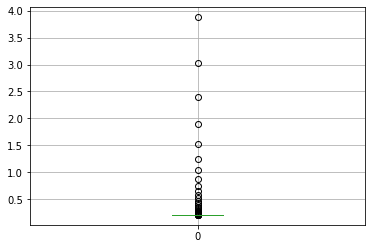

In [16]:
print(dtrain.describe())
dtrain.boxplot()
plt.show()

In [17]:
print("Best MAE on Validation Set =", max(history['val_mae']))

Best MAE on Validation Set = 0.4721794128417969


In [18]:
print("Best MSE on Validation Set =", max(history['val_mse']))

Best MSE on Validation Set = 0.345486044883728


In [19]:
loss = model.evaluate(X_train, X_train, verbose=0)
print(loss)

[0.2069023847579956, 0.20658136904239655, 0.07121867686510086, 330.4071960449219, 0.015472246333956718, 0.8989683985710144]


In [20]:
for name, value in zip(model.metrics_names, loss):
    print(name, value)

loss 0.2069023847579956
mae 0.20658136904239655
mse 0.07121867686510086
mape 330.4071960449219
msle 0.015472246333956718
cosine_proximity 0.8989683985710144


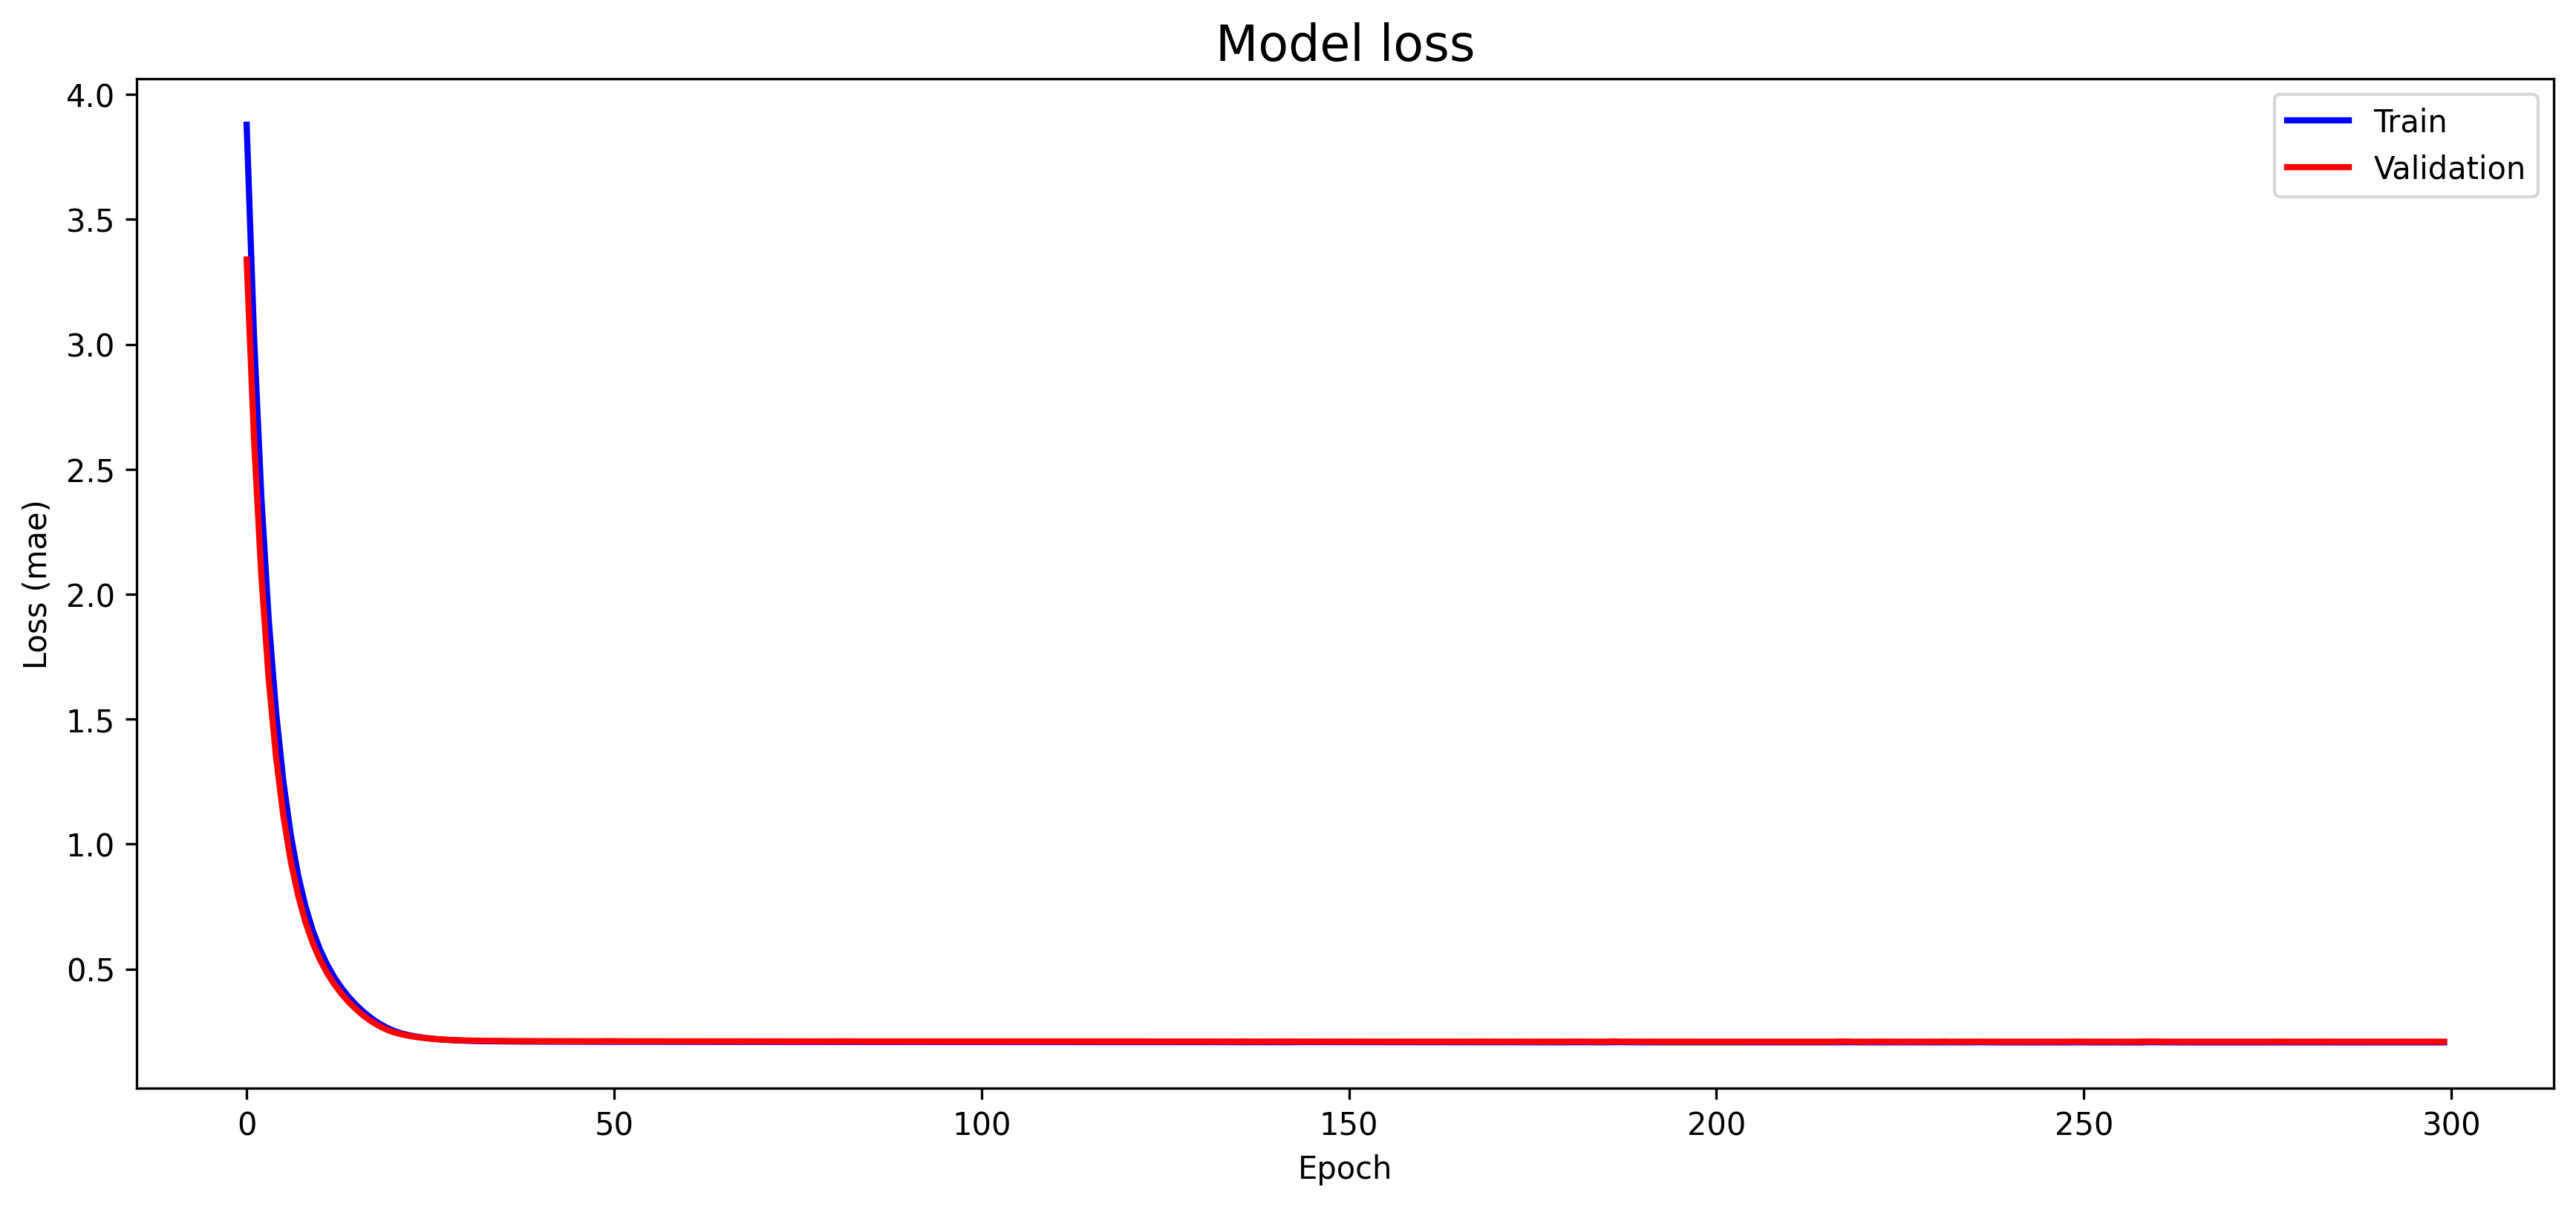

In [21]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()



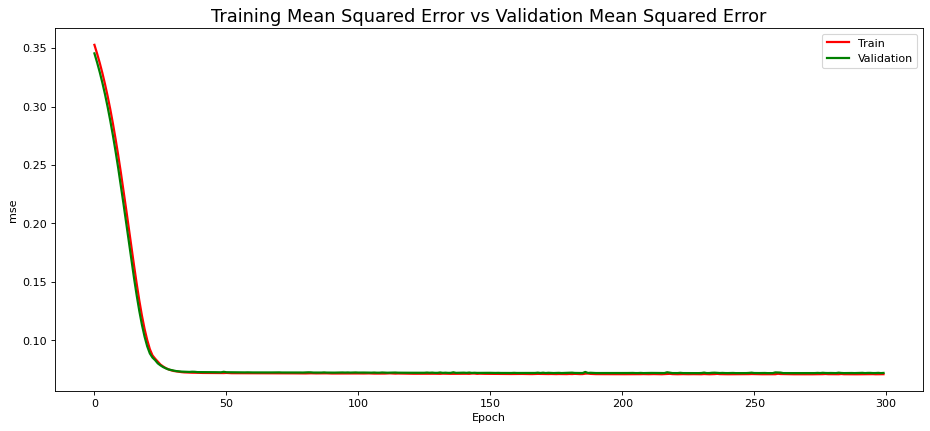

In [22]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['mse'], 'r', label='Train', linewidth=2)
ax.plot(history['val_mse'], 'g', label='Validation', linewidth=2)
ax.set_title('Training Mean Squared Error vs Validation Mean Squared Error', fontsize=16)
ax.set_ylabel('mse')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

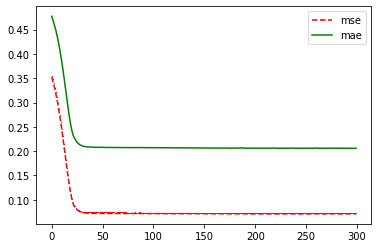

In [23]:
# plot metrics
plt.plot(history['mse'],'r--,', label='mse')
plt.plot(history['mae'],'g', label='mae')
plt.legend(loc='upper right')
plt.show()

## Distributon of Loss Function

/home/zan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

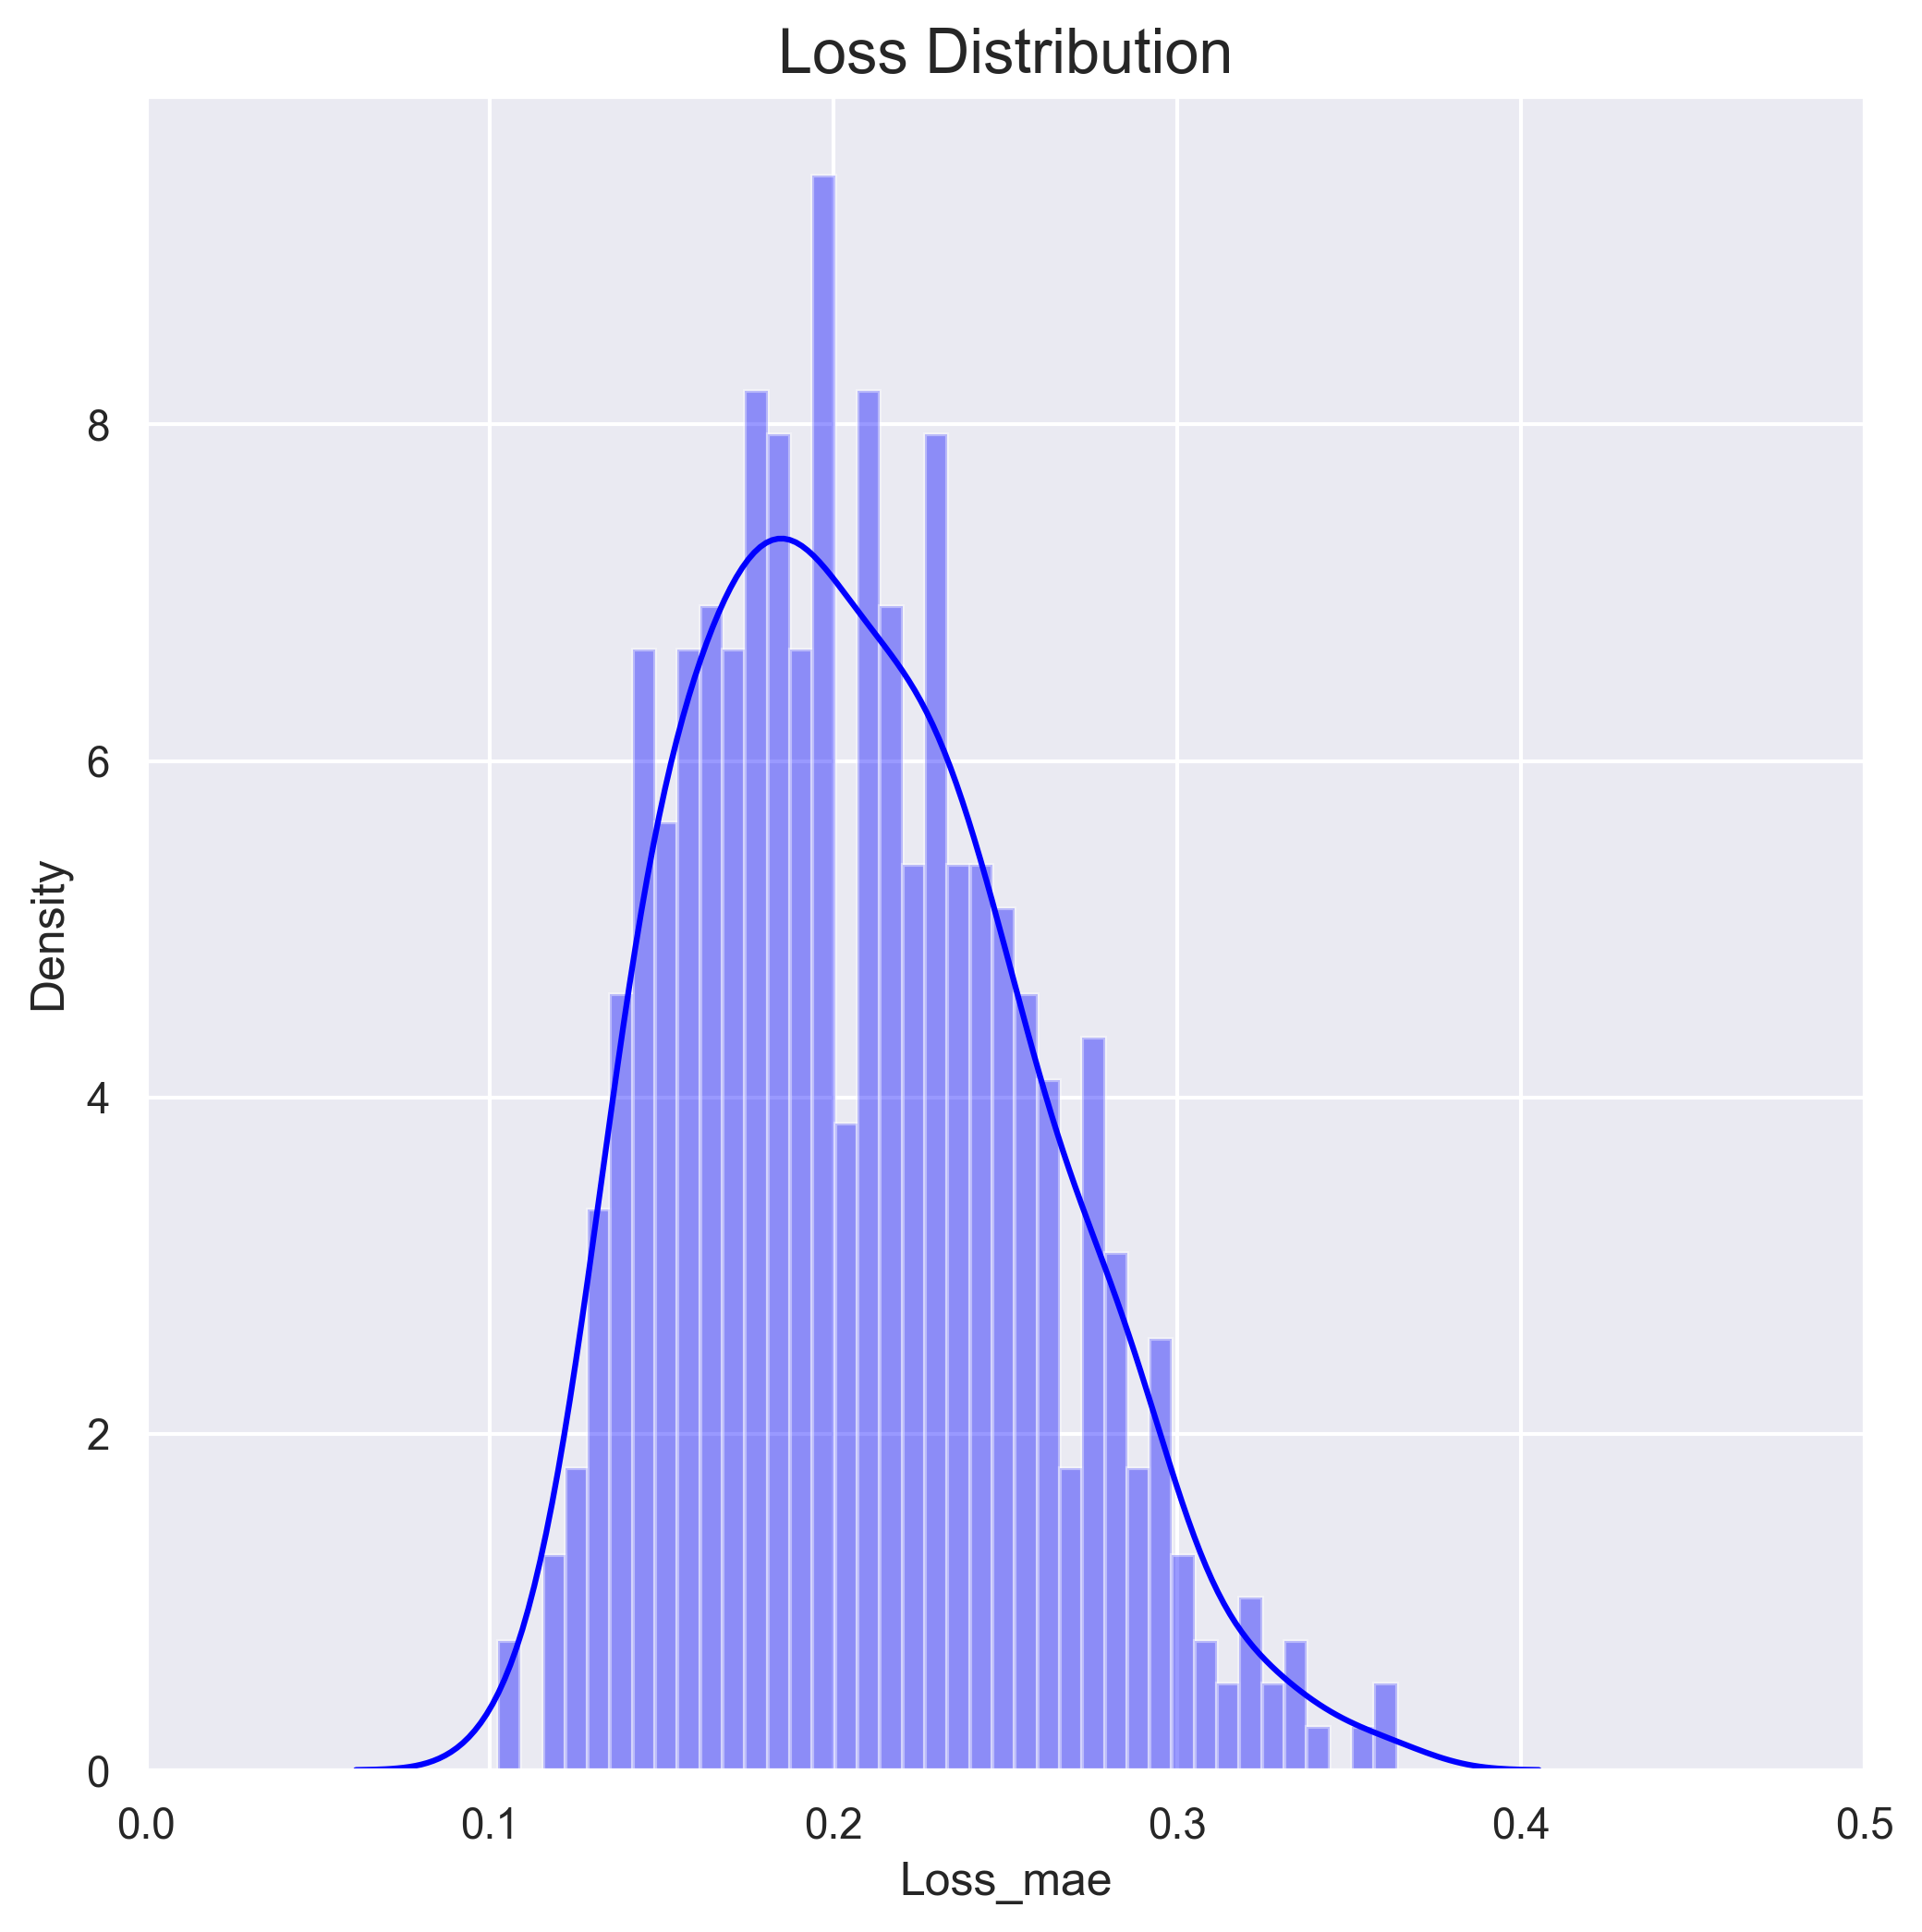

In [24]:
import seaborn as sns
sns.set(color_codes=True)

# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train_ext.columns)
X_pred.index = train_ext.index

scored_train = pd.DataFrame(index=train_ext.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored_train['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)

plt.figure(figsize=(8,8), dpi= 300)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored_train['Loss_mae'], color = 'blue', bins = 40, kde=True)
plt.xlim([0.00,0.5])


/home/zan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,Loss_mae,Threshold,Anomaly
0,0.662140,0.9,False
1,0.659707,0.9,False
2,0.663444,0.9,False
3,0.761296,0.9,False
4,0.817082,0.9,False


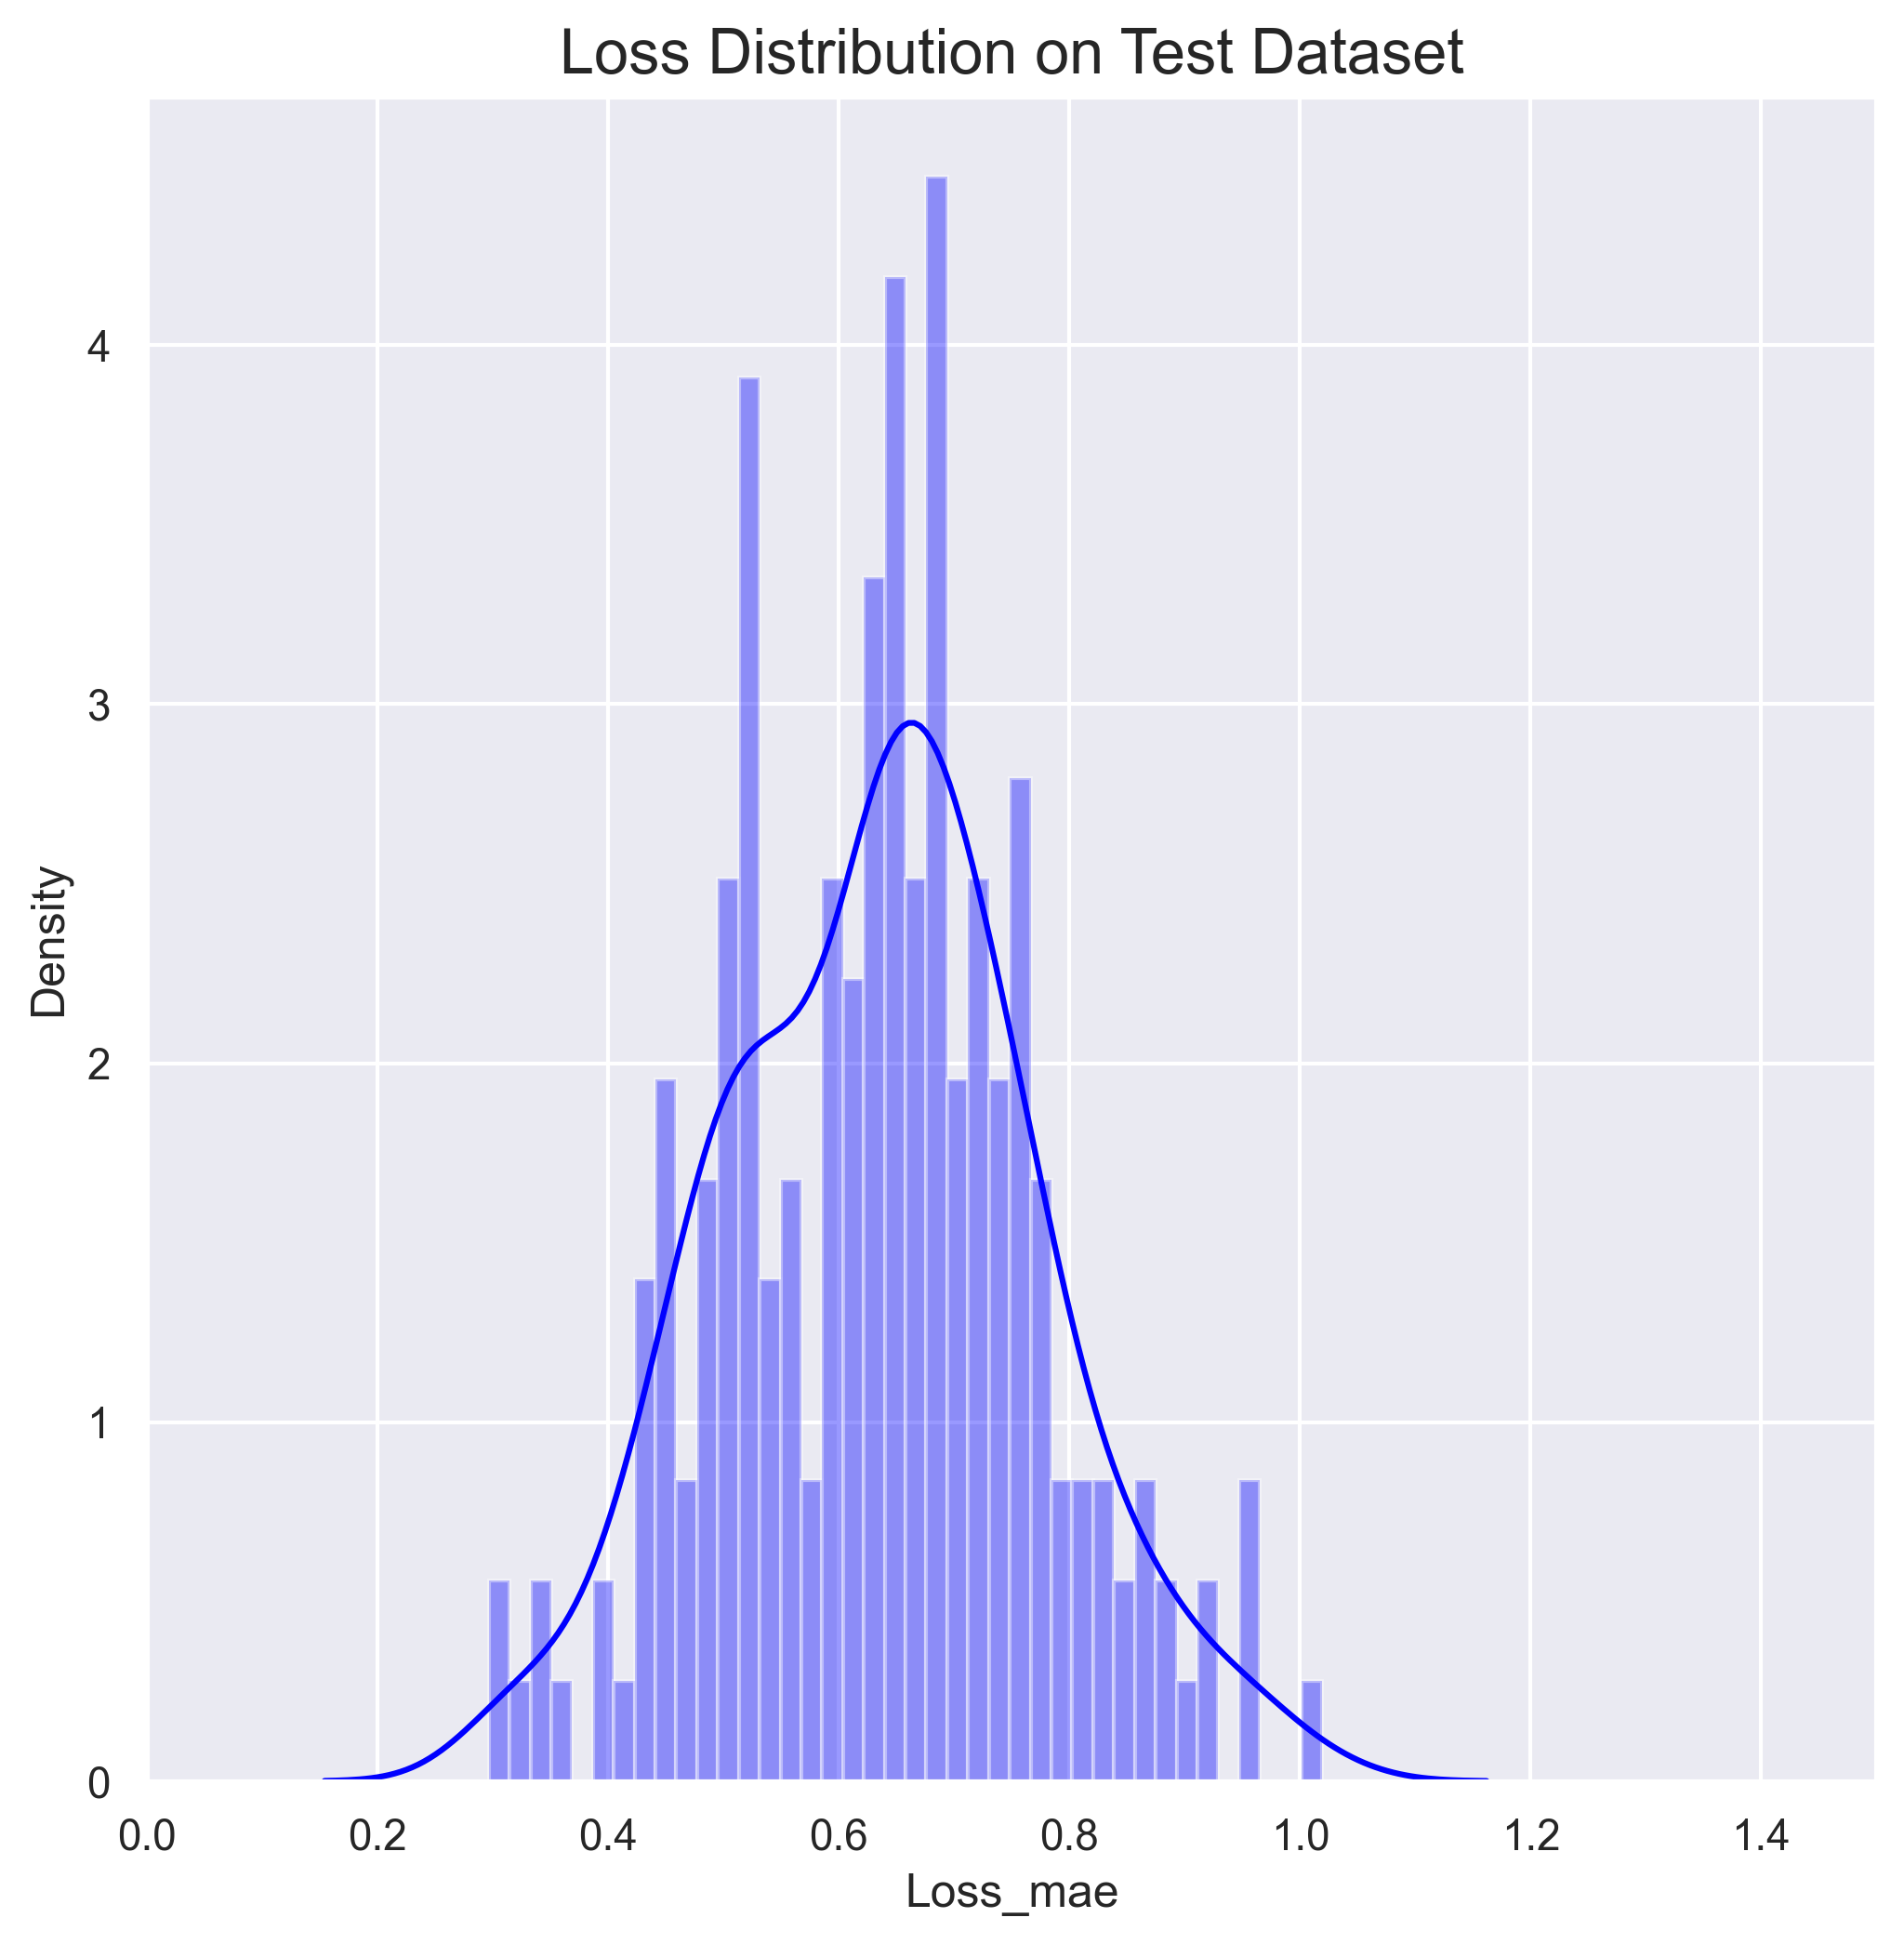

In [25]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test_ext.columns)
X_pred.index = test_ext.index


scored = pd.DataFrame(index=test_ext.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])

scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)

plt.figure(figsize=(8,8), dpi= 300)
plt.title('Loss Distribution on Test Dataset', fontsize=16)
sns.distplot(scored['Loss_mae'], color = 'blue', bins = 40, kde=True)
plt.xlim([0.00,1.5])
scored['Threshold'] = 0.9
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

In [26]:
scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Loss_mae   198 non-null    float32
 1   Threshold  198 non-null    float64
 2   Anomaly    198 non-null    bool   
dtypes: bool(1), float32(1), float64(1)
memory usage: 2.6 KB


In [27]:
data_filter = scored[scored['Anomaly'] == True]
data_filter.head(100)

,Loss_mae,Threshold,Anomaly
22,1.019409,0.9,True
53,0.959918,0.9,True
70,0.965030,0.9,True
73,0.954680,0.9,True
165,0.922790,0.9,True
179,0.927471,0.9,True


In [28]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train_ext.columns)
X_pred_train.index = train_ext.index

scored_train = pd.DataFrame(index=train_ext.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.9
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

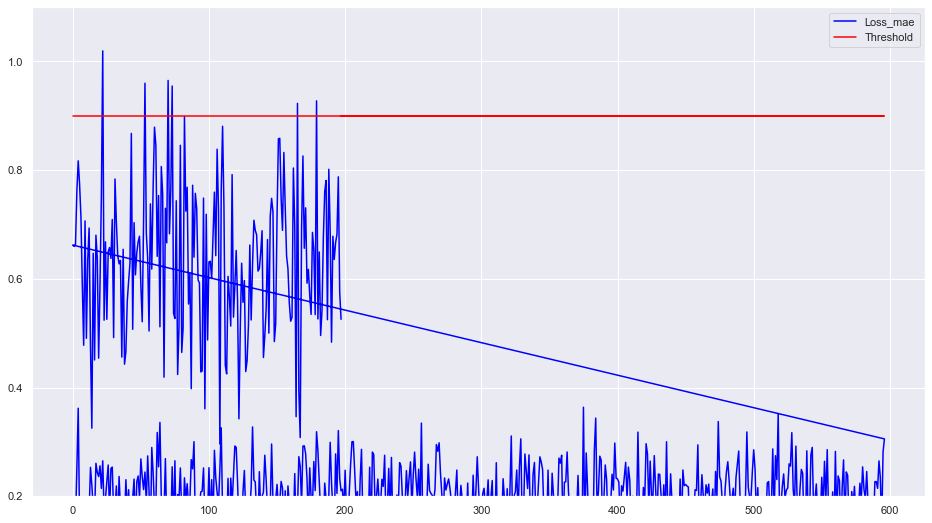

In [29]:
scored.plot(figsize=(16,9), ylim=[0.2,1.1], color=['blue','red'])

In [30]:
## Determinación de threshold con (max)

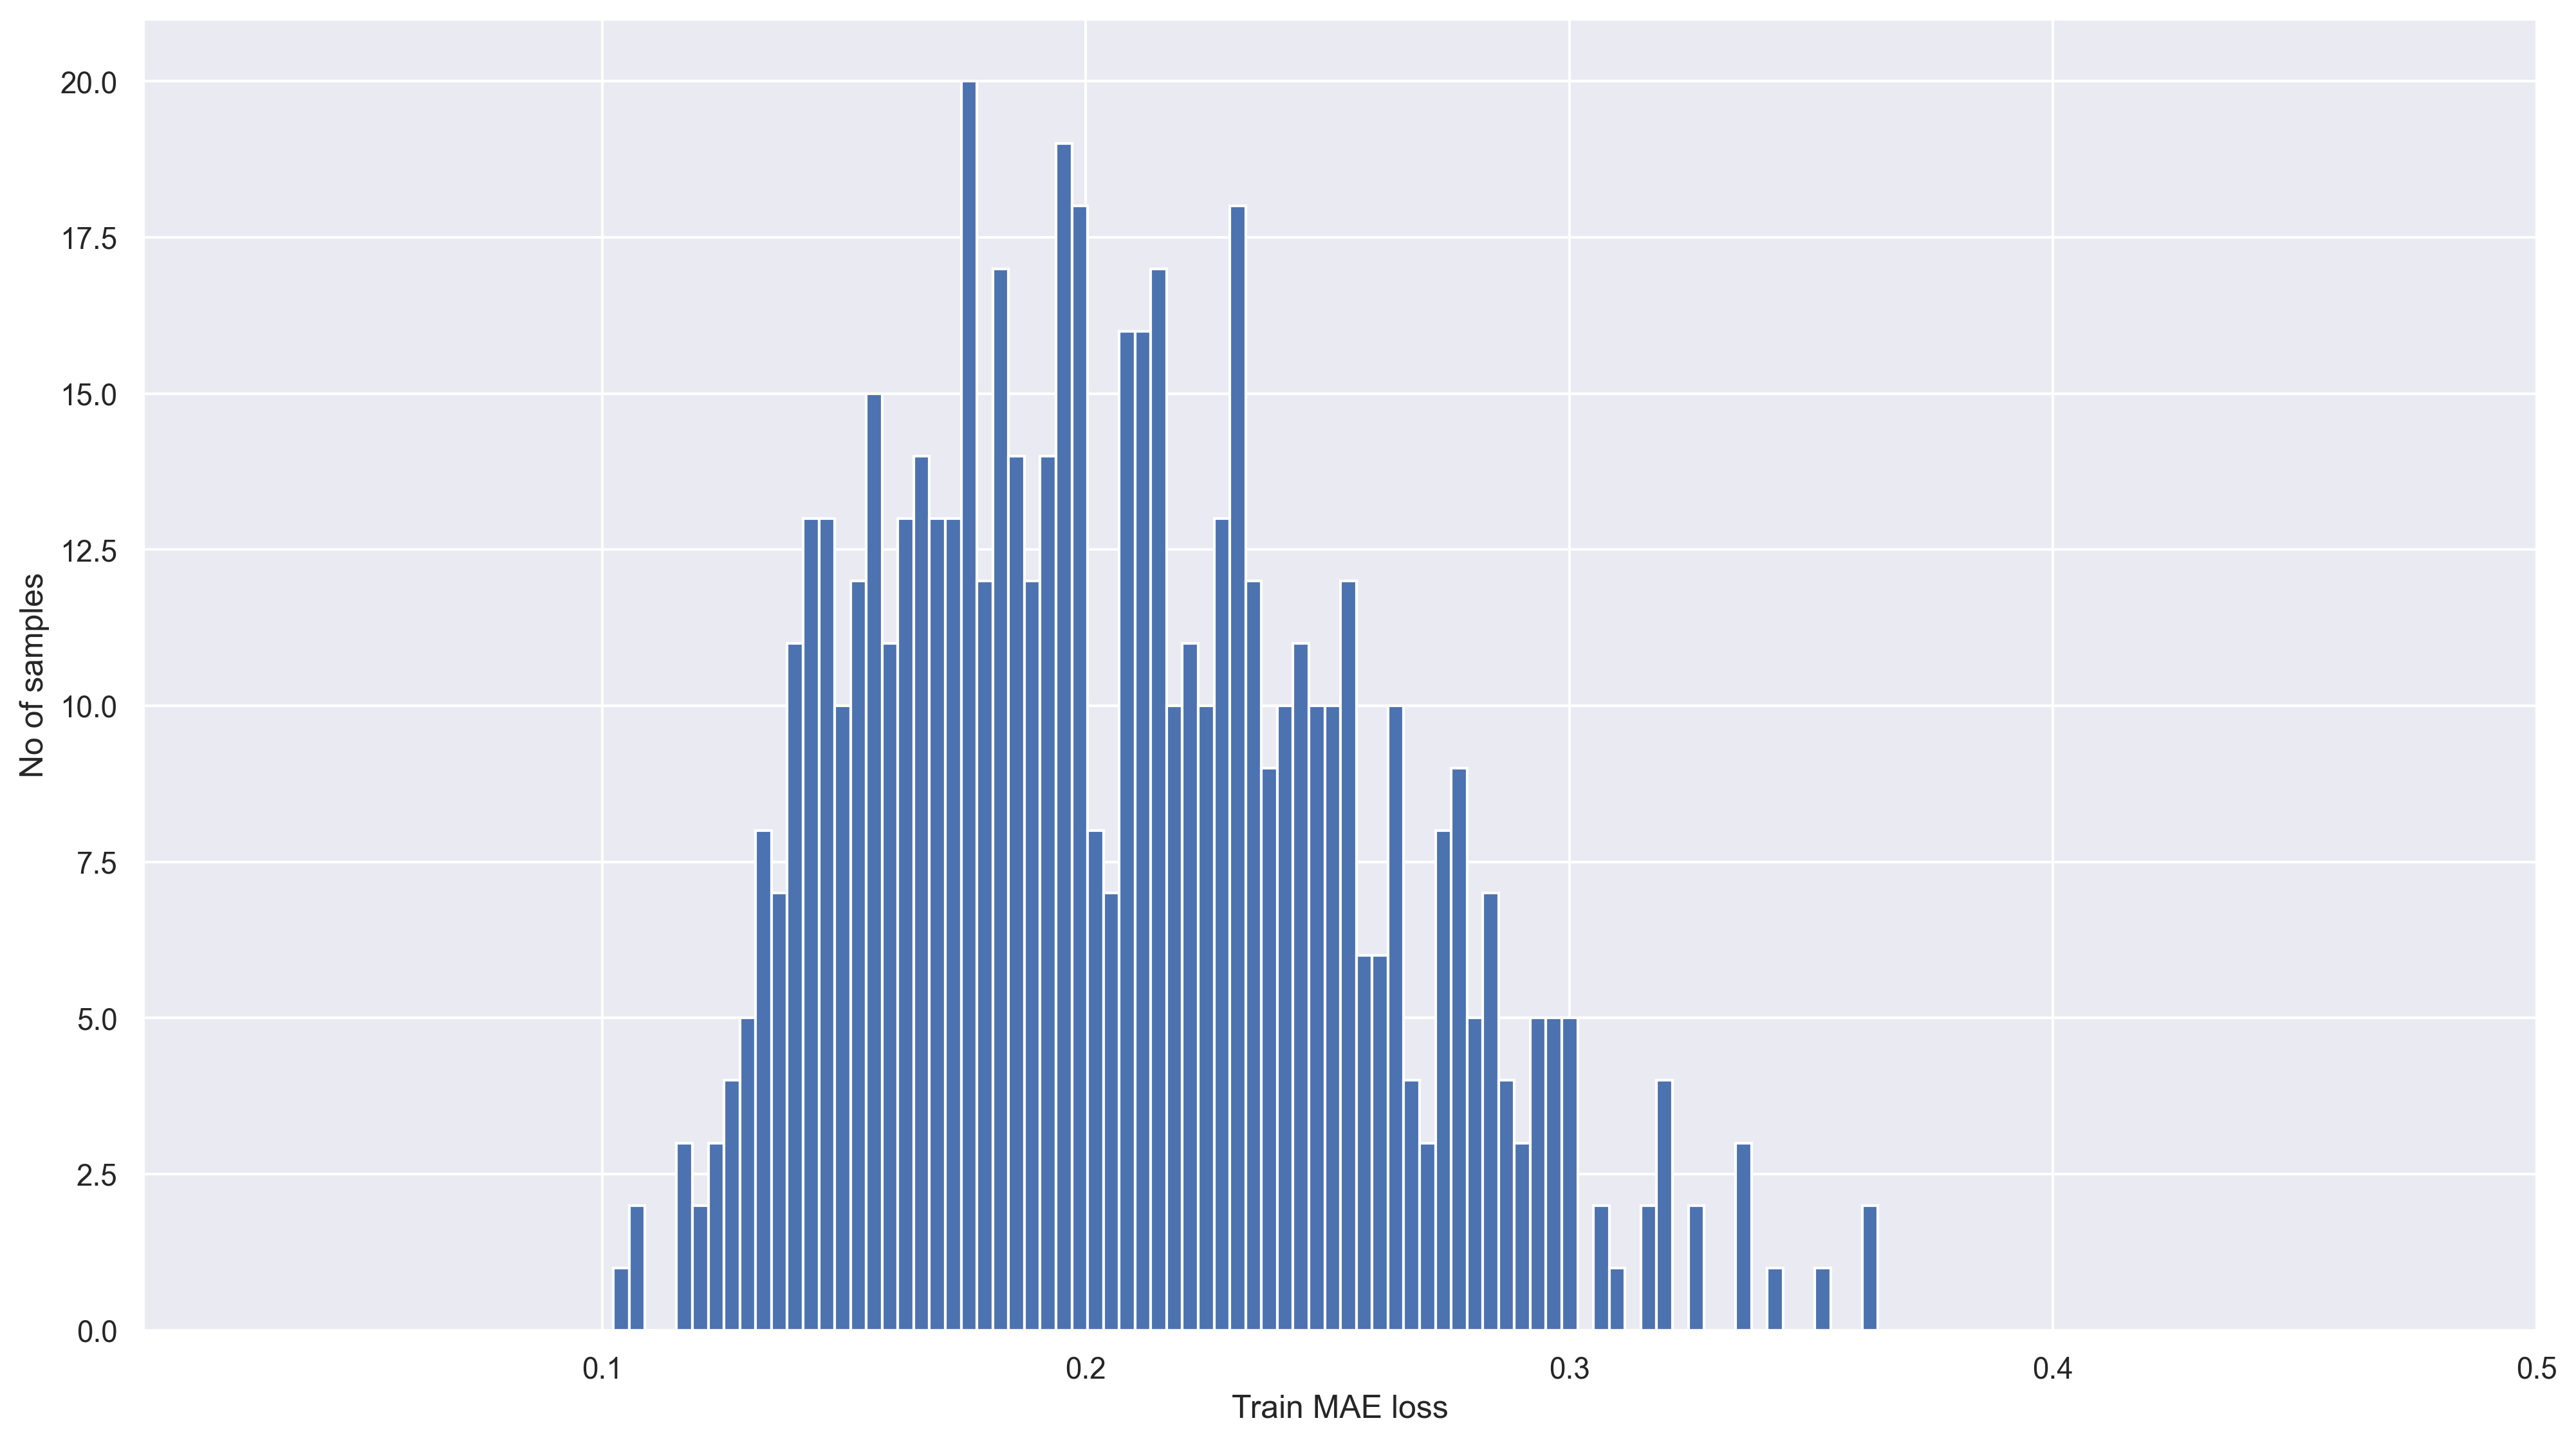

Reconstruction error threshold:  0.36378938


In [33]:
# Get train MAE loss.
x_train_pred = model.predict(X_train)
x_train_pred = x_train_pred.reshape(x_train_pred.shape[0], x_train_pred.shape[2])
x_train_pred = pd.DataFrame(x_train_pred, columns=train_ext.columns)
x_train_pred.index = train_ext.index

score = pd.DataFrame(index=train_ext.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
score['train_mae_loss'] = np.mean(np.abs(x_train_pred - Xtrain), axis=1)

plt.figure(figsize=(16,9), dpi= 300)
plt.hist(score['train_mae_loss'], bins= 80)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.xlim([0.005,0.5])
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(score['train_mae_loss'])
print("Reconstruction error threshold: ", threshold)

In [34]:
## Determinación de threshold con (mean + std)

In [35]:
reconstructions = model.predict(X_train)
train_loss = np.mean(np.abs(reconstructions - X_train), axis=1)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


Threshold:  0.37552756


## Determinación de Clasificación. Test

In [36]:
# calculate the loss on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, cohen_kappa_score, fbeta_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, log_loss
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test_ext.columns)
X_pred.index = test_ext.index


In [37]:
error_df = pd.DataFrame(index=test_ext.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
error_df['Reconstruction_error'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
error_df['True_class'] = test_dec_a
error_df.head()

## Otra variante
"""
mse = np.mean(np.power(Xtest - X_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()
"""

"\nmse = np.mean(np.power(Xtest - X_pred, 2), axis=1)\nerror_df = pd.DataFrame({'Reconstruction_error': mse,\n                        'True_class': test_y})\nerror_df.describe()\n"

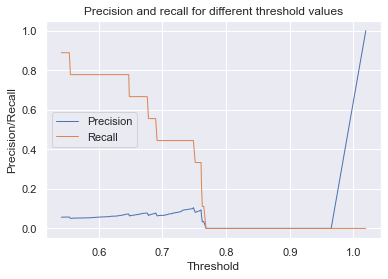

In [38]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()


In [39]:
print(threshold_rt)

[0.5412842  0.54447955 0.55371195 0.5553549  0.55677956 0.55864894
 0.5591958  0.5662371  0.56950986 0.5757496  0.585391   0.58706474
 0.58765227 0.591657   0.5920341  0.59236133 0.59572715 0.59700966
 0.5981222  0.6004018  0.60455656 0.607387   0.61065745 0.61432904
 0.6174408  0.6180458  0.6188724  0.6188745  0.62634635 0.6275819
 0.62880194 0.62889975 0.6312197  0.6324416  0.6338805  0.6355966
 0.63610506 0.6376629  0.6379457  0.63816893 0.6398934  0.64143205
 0.64166284 0.6427068  0.643136   0.647028   0.6479837  0.64822346
 0.64945686 0.6497995  0.65220314 0.6525664  0.6543978  0.6562536
 0.65765756 0.65970725 0.66214    0.6621914  0.66344416 0.6662331
 0.6667983  0.66807157 0.6682187  0.67237693 0.6761955  0.67799854
 0.6783975  0.6784379  0.68030113 0.68102807 0.681953   0.68284976
 0.68377876 0.685447   0.6874395  0.68848866 0.68924975 0.68931854
 0.6915822  0.6935559  0.69530934 0.7034515  0.704497   0.70656466
 0.7078213  0.7091355  0.7094162  0.713505   0.7156444  0.7157774


## ROC CURVE CHECK

Text(0.5, 0, 'False Positive Rate')

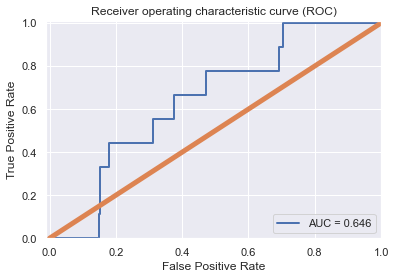

In [40]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


## RECALL VS PRECISION THRESHOLDING

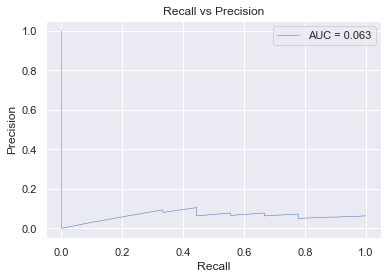

In [41]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
pr_auc = auc(recall_rt, precision_rt,)

plt.plot(recall_rt, precision_rt, linewidth=0.5, label='AUC = %0.3f'% pr_auc)
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


## Reconstruction Error vs Threshold Check

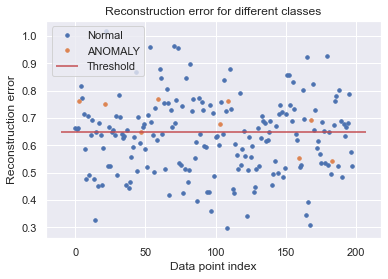

In [42]:
threshold_fixed = 0.65
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "ANOMALY" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()



## Confusion Matrix

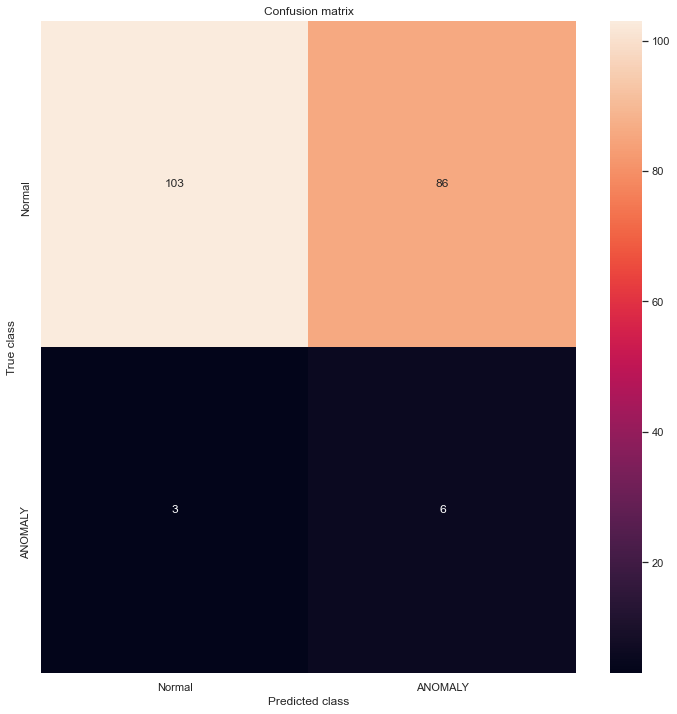

In [43]:
import seaborn as sns
LABELS = ["Normal","ANOMALY"]

pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()



## MODEL STATS

In [44]:
def print_stats(ytest, ypred):
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    ll = log_loss(ytest, ypred)
    print("Log Loss: {}".format(ll))
    print(' ')
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [45]:
print_stats(error_df.True_class, pred_y)

Accuracy: 0.55051, Cohen's Kappa Score: 0.03925
Log Loss: 15.525352851141651
 
Confusion Matrix:
[[103  86]
 [  3   6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.54      0.70       189
           1       0.07      0.67      0.12         9

    accuracy                           0.55       198
   macro avg       0.52      0.61      0.41       198
weighted avg       0.93      0.55      0.67       198



In [46]:
p = precision_score(error_df.True_class, pred_y,average='weighted')
r = recall_score(error_df.True_class, pred_y,average='weighted')
f = fbeta_score(error_df.True_class, pred_y, beta= 1,average='weighted')
print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))

Result: p=0.930, r=0.551, f=0.672


In [47]:
print("------------------------------------------------------------------------------")
for threshold_fixed in [0.4, 0.65, 0.7, 0.8]:
    pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.True_class, pred_y)
    #print(conf_matrix)
    p = precision_score(error_df.True_class, pred_y, average='weighted')
    r = recall_score(error_df.True_class, pred_y,average='weighted')
    f = fbeta_score(error_df.True_class, pred_y, beta= 1, average='weighted')
    print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))
    print('Threshold fixed=%.3f' % threshold_fixed)
    print_stats(error_df.True_class, pred_y)
    print("------------------------------------------------------------------------------")

------------------------------------------------------------------------------
Result: p=0.957, r=0.086, f=0.082
Threshold fixed=0.400
Accuracy: 0.08586, Cohen's Kappa Score: 0.00400
Log Loss: 31.574056841483323
 
Confusion Matrix:
[[  8 181]
 [  0   9]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08       189
           1       0.05      1.00      0.09         9

    accuracy                           0.09       198
   macro avg       0.52      0.52      0.09       198
weighted avg       0.96      0.09      0.08       198

------------------------------------------------------------------------------
Result: p=0.930, r=0.551, f=0.672
Threshold fixed=0.650
Accuracy: 0.55051, Cohen's Kappa Score: 0.03925
Log Loss: 15.525352851141651
 
Confusion Matrix:
[[103  86]
 [  3   6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.54      0.70       189
        